In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, norm
import warnings
from time import time

from typing import Dict, List, Tuple

warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Input, Dense, Activation, LeakyReLU, PReLU, ELU, Dropout

import xgboost as xgb
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
import lightgbm as lgb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv
/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [2]:
def show(df, n_rows=5, sort=None):
    if n_rows == 'all':
        if sort is not None:
            df = df.sort_values(sort, ascending=False)
        display(df.head(df.shape[0]))
        print(f"{df.shape[0]} rows x {df.shape[1]} columns")
    else:
        if sort:
            df = df.sort_values(sort, ascending=False)
        display(df.head(n_rows))
        print(f"{df.shape[0]} rows x {df.shape[1]} columns")

In [3]:
global device

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
    device = 'gpu'
else:
    print("GPU is not available")
    device = 'cpu'

GPU is not available


## Load data

In [4]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
show(train_df)

test_df = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
show(test_df)

submission=pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
show(submission)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


2190 rows x 13 columns


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


730 rows x 12 columns


,id,rainfall
0,2190,0
1,2191,0
2,2192,0
3,2193,0
4,2194,0


730 rows x 2 columns


In [5]:
train = train_df.drop(columns=["id"])
test = test_df.drop(columns=["id"])

train_copy=train.copy()
test_copy=test.copy()

target = 'rainfall'

show(train)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


2190 rows x 12 columns


# EDA

## Check missing values

In [6]:
out_cols = ['Feature', 'Data Type', 'Train Missing %', 'Test Missing %', "Original Missing%", "Discrete Ratio (Train)"]
out = []

for col in train_copy.columns:

    if col == target:
        continue
    
    data_type = train_copy[col].dtype

    train_missing_share = round(train_copy[col].isna().sum() / train_copy.shape[0], 2)

    test_missing_share = round(test_copy[col].isna().sum() / test_copy.shape[0], 2)

    # Calculate discrete nature ratio (unique values / total values)
    discrete_ratio = round(train_copy[col].nunique() / train_copy.shape[0], 3)

    out.append([col, data_type, train_missing_share, test_missing_share, original_missing_share, discrete_ratio])

table = pd.DataFrame.from_records(out, columns = out_cols)

show(table, 20)

,Feature,Data Type,Train Missing %,Test Missing %,Original Missing%,Discrete Ratio (Train)
0,day,int64,0.0,0.0,0.0,0.167
1,pressure,float64,0.0,0.0,0.0,0.108
2,maxtemp,float64,0.0,0.0,0.0,0.100
3,temparature,float64,0.0,0.0,0.0,0.090
4,mintemp,float64,0.0,0.0,0.0,0.091
5,dewpoint,float64,0.0,0.0,0.0,0.100
6,humidity,float64,0.0,0.0,0.0,0.022
7,cloud,float64,0.0,0.0,0.0,0.036
8,sunshine,float64,0.0,0.0,0.0,0.055
9,winddirection,float64,0.0,0.0,0.0,0.016


11 rows x 6 columns


## Target distribution

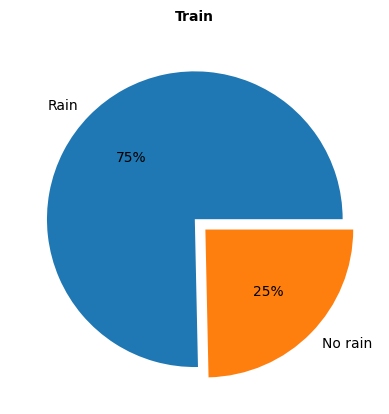

In [7]:
# Target distribution

# Data
data_train = [train['rainfall'].sum(), train['rainfall'].shape[0] - train['rainfall'].sum()]
labels = ['Rain', 'No rain']

# Explode "No rain" slice
explode = [0, 0.1]

plt.pie(data_train, labels = labels, explode = explode, autopct='%.0f%%')
plt.title('Train', fontsize=10, fontweight='bold', pad=10)

plt.show()

## Train and test variable distribution

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

ax = ax.flatten()

i = 0
for col in train_copy.columns:
    if col != 'rainfall':
        sns.kdeplot(data=train_copy, x=col, ax=ax[i], label='Train', fill=True)
        sns.kdeplot(data=test_copy, x=col, ax=ax[i], label='Test', fill=True)
        ax[i].set_title(col)
        ax[i].legend()
        
        i+=1

plt.tight_layout()

for j in range (i, len(ax)):
    ax[j].axis('off')

plt.show()

## Variable distribution by class

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

ax = ax.flatten()

train_pos = train_copy[train_copy['rainfall'] == 1]
train_neg = train_copy[train_copy['rainfall'] == 0]

i = 0
for col in train_copy.columns:
    if col != 'rainfall':
        sns.kdeplot(data=train_pos, x=col, ax=ax[i], label='Rain', fill=True)
        sns.kdeplot(data=train_neg, x=col, ax=ax[i], label='No rain', fill=True)
        ax[i].set_title(col)
        ax[i].legend()
        
        i+=1

plt.tight_layout()

for j in range (i, len(ax)):
    ax[j].axis('off')

plt.show()

# Feature engineering

In [ ]:
def one_hot_encode_with_dropping(train_df: pd.DataFrame, test_df: pd.DataFrame, columns: List, target: str):
    '''
    Function for one hot encoding.
    
        1. Combine the data (avoid missing any category)
        2. Drop the least frequent category 
    '''
    dataset = pd.concat([train_df, test_df], axis=0)
    
    for col in columns:
        # One hot encoding
        one_hot = pd.get_dummies(dataset[col])

        # Get the least frequent category
        counts = dataset[col].value_counts() 
        min_count_category = counts.idxmin()

        # Drop the least frequent category
        one_hot = one_hot.drop(min_count_category, axis=1)

        # Naming of one hot encoded columns
        one_hot.columns=[str(f) + col + "_OHE" for f in one_hot.columns]
        
        dataset = pd.concat([dataset, one_hot], axis="columns")
        dataset = dataset.loc[:, ~dataset.columns.duplicated()]
    
    # Split back to train and test dataframes
    train_ohe = dataset[:len(train_df)]
    test_ohe = dataset[len(train_df):]
    
    test_ohe.reset_index(inplace=True,drop=True)
    test_ohe.drop(columns=[target],inplace=True)
    
    return train_ohe, test_ohe

In [ ]:
train_median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
columns = [i for i in train_copy.columns if i != 'rainfall']
print(columns)

train_imputed = train_median_imputer.fit_transform(train_copy[columns])
train_imputed = pd.DataFrame(train_imputed, columns=columns)
train_imputed['rainfall'] = train_copy['rainfall'].copy()
print(train_imputed.isna().sum())
show(train_imputed)

test_imputed = train_median_imputer.transform(test_copy)
test_imputed = pd.DataFrame(test_imputed, columns=columns)
print(test_imputed.isna().sum())
show(test_imputed)

# Feature selection

In [ ]:
final_features = [f for f in train_imputed.columns if f not in [target]]
final_features = [*set(final_features)]

standard_scaler = StandardScaler()

train_scaled = train_imputed.copy()
train_scaled[final_features] = standard_scaler.fit_transform(train_imputed[final_features])

test_scaled = test_imputed.copy()
test_scaled[final_features] = standard_scaler.transform(test_imputed[final_features])

In [ ]:
X_train = train_scaled.drop(columns=[target])
y_train = train[target]

X_test = test_scaled.copy()

print(X_train.shape, X_test.shape)

In [ ]:
# Function copied from user: https://www.kaggle.com/arunklenin

def get_most_important_features(X_train, y_train, n,model_input):
    xgb_params = {
            'n_jobs': -1,
            'eval_metric': 'logloss',
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': 42,
        }
    if device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
    lgb_params = {
            'objective': 'binary',
            'metric': 'logloss',
            'boosting_type': 'gbdt',
            'random_state': 42,
            'device': device,
            'verbose':-1
        }
    cb_params = {
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'AUC',
            'loss_function': 'Logloss',
            'random_state': 42,
            'task_type': device.upper(),
        }
    if 'xgb' in model_input:
        model = xgb.XGBClassifier(**xgb_params)
    elif 'cat' in model_input:
        model=CatBoostClassifier(**cb_params)
    else:
        model=lgb.LGBMClassifier(**lgb_params)
        
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    feature_importances_list = []
    
    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        if "lgb" not in model_input:
            model.fit(X_train_fold, y_train_fold, verbose=False)
        else:
            model.fit(X_train_fold, y_train_fold)
            
        
        y_pred = model.predict_proba(X_val_fold)[:,1]
        auc_scores.append(roc_auc_score(y_val_fold, y_pred))
        feature_importances = model.feature_importances_
        feature_importances_list.append(feature_importances)

    avg_auc= np.mean(auc_scores)
    avg_feature_importances = np.mean(feature_importances_list, axis=0)

    feature_importance_list = [(X_train.columns[i], importance) for i, importance in enumerate(avg_feature_importances)]
    sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
    top_n_features = [feature[0] for feature in sorted_features[:n]]

    display_features=top_n_features[:10]
    
    sns.set_palette("Set2")
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(display_features)), [avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features])
    plt.yticks(range(len(display_features)), display_features, fontsize=12)
    plt.xlabel('Average Feature Importance', fontsize=14)
    plt.ylabel('Features', fontsize=10)
    plt.title(f'Top {10} of {n} Feature Importances with ROC AUC score {avg_auc}', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Add data labels on the bars
    for index, value in enumerate([avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features]):
        plt.text(value + 0.005, index, f'{value:.3f}', fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

    return top_n_features

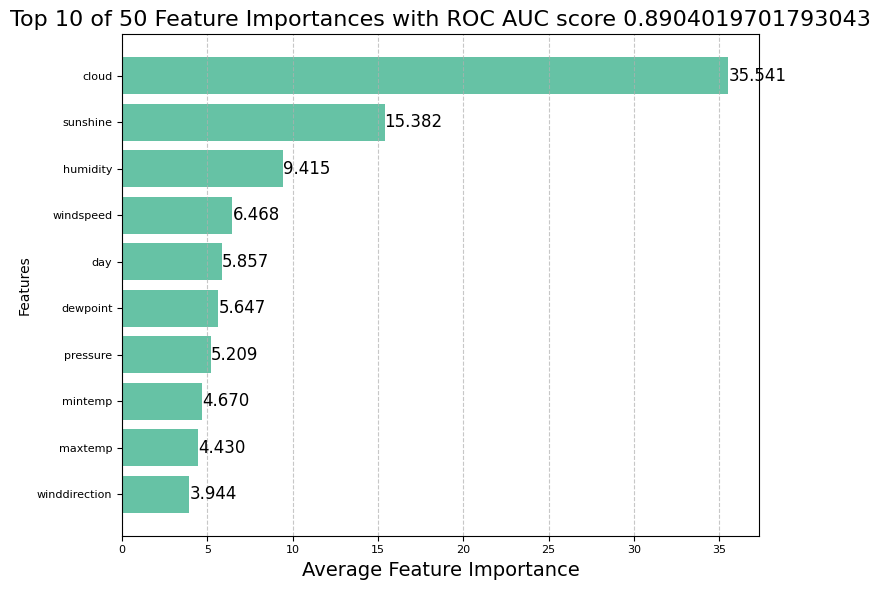

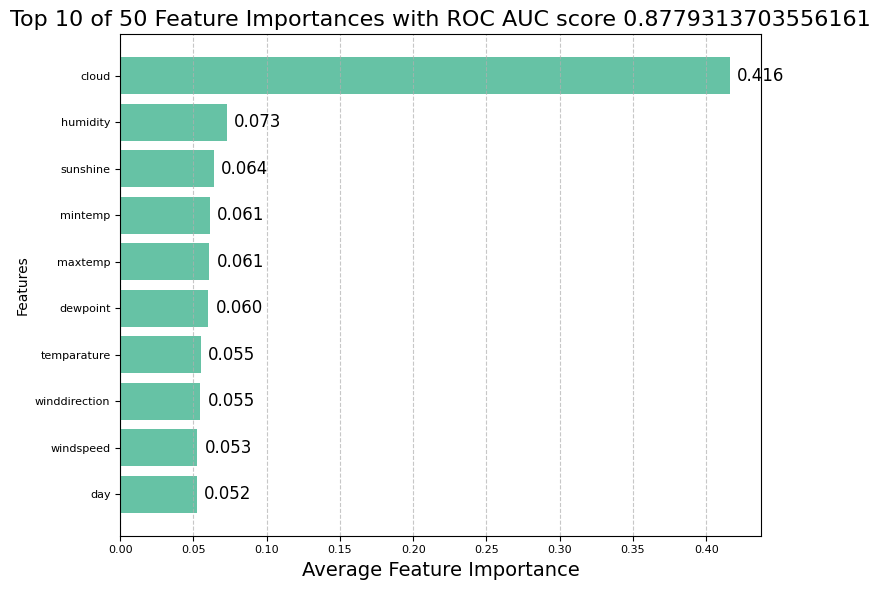

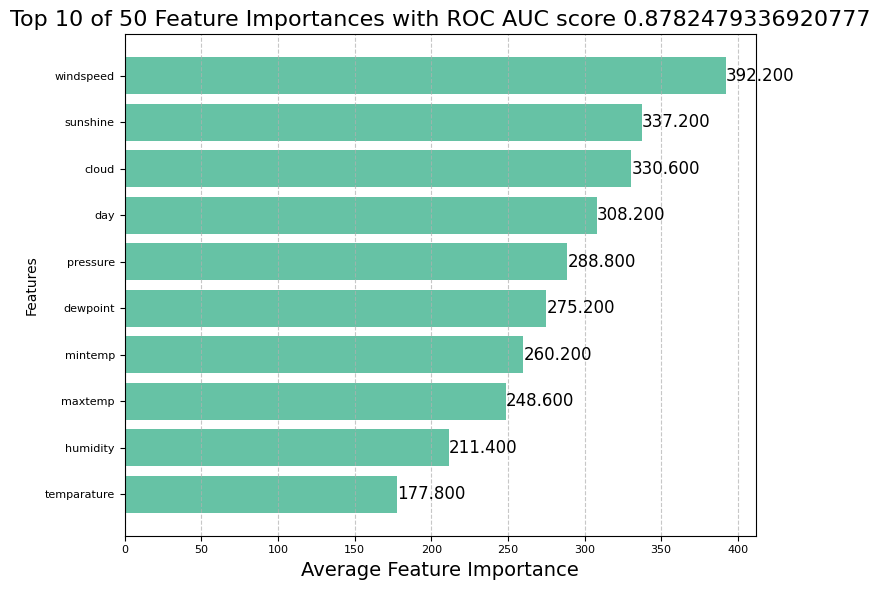

In [15]:
n_imp_features_cat=get_most_important_features(X_train.reset_index(drop=True), y_train,50, 'cat')
n_imp_features_xgb=get_most_important_features(X_train.reset_index(drop=True), y_train,50, 'xgb')
n_imp_features_lgbm=get_most_important_features(X_train.reset_index(drop=True), y_train,50, 'lgbm')

In [16]:
n_imp_features = [*set(n_imp_features_xgb + n_imp_features_lgbm + n_imp_features_cat)]
print(f"{len(n_imp_features)} features have been selected from three algorithms for the final model")

X_train = X_train[n_imp_features]
X_test = X_test[n_imp_features]

11 features have been selected from three algorithms for the final model


# Modelling

## Get class weights

In this dataset positive and negative classes are quite imbalanced so I will use class weights and pass them to the models rather then do any sampling.

In [17]:
classes = np.unique(y_train)  
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
y_train_numeric = np.array([class_to_index[cls] for cls in y_train])

class_counts = np.bincount(y_train_numeric)

total_samples = len(y_train_numeric)

class_weights = total_samples / (len(classes) * class_counts)

class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

print("Class labels:", list(range(0, len(class_counts))))
print("Class counts:", class_counts)
print("Total samples:", total_samples)
print("Class weights:", class_weights)
print("Class weights dictionary:", class_weights_dict)

Class labels: [0, 1]
Class counts: [ 540 1650]
Total samples: 2190
Class weights: [2.02777778 0.66363636]
Class weights dictionary: {0: 2.0277777777777777, 1: 0.6636363636363637}


## Define models

In [18]:
# TODO: add additional optimizers (RMSprop Adam, Nadam, AdamW)

def get_optimizer():
    sgd_opt = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.5, nesterov=True)
    
    return sgd_opt

sgd_opt = get_optimizer()

In [19]:
# Define neural network
nn = Sequential()
nn.add(Dense(16, input_dim=X_test.shape[1], kernel_initializer='he_uniform', activation='relu'))
nn.add(Dropout(0.1))
nn.add(Dense(4, kernel_initializer='he_uniform', activation='relu'))
nn.add(Dropout(0.0))
nn.add(Dense(2, kernel_initializer='he_uniform', activation='softmax'))

roc_auc = tf.keras.metrics.AUC(
    num_thresholds=200,
    curve='ROC'
)

nn.compile(loss='binary_crossentropy', optimizer=sgd_opt, metrics=['accuracy', roc_auc])

In [35]:
class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._get_models()

    def _get_models(self):

        # XGBoost model parameters
        xgb_params = {
           'n_estimators': self.n_estimators,
           'learning_rate': 0.05,
           'max_depth': 4,
           'subsample': 0.8,
           'colsample_bytree': 0.1,
           'n_jobs': -1,
           'eval_metric': 'auc',
           'objective': 'binary:logistic',
           'tree_method': 'hist',
           'verbosity': 0,
           'random_state': self.random_state
        }
        
        if self.device == 'gpu':
            xgb_params.update({
                'tree_method': 'gpu_hist',
                'predictor': 'gpu_predictor',
                'device': 'cuda',
                'booster': 'gbtree'
            })

        # LightGBM model parameters
        lgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 10, 
            'min_samples_leaf': 30, 
            'subsample': 0.8, 
            'learning_rate': 0.005, 
            'lambda_l1': 0.00001, 
            'lambda_l2': 0.0005,
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
            'verbose': -1
        }
        cb_params = {
            'iterations': self.n_estimators,
            'depth': 6,
            'learning_rate': 0.05,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'AUC',
            'loss_function': 'Logloss',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
            'verbose': -1
        }

        # DBSCAN
        dbscan_params = {
            'p': 1
        }
        
        knn_params = {
            'n_neighbors': 100, 
            'p': 1
        }
        
        models = {
            'xgb_model': xgb.XGBClassifier(**xgb_params),
            'lgb_model': lgb.LGBMClassifier(**lgb_params),
            'cb_model':  CatBoostClassifier(**cb_params),
            'knn': KNeighborsClassifier(**knn_params),
            'dbscan': DBSCAN(**dbscan_params)
        }
        
        return models

In [23]:
class TrainTestSplitter:
    def __init__(self, test_size=0.2, n_splits=0):
        self.test_size = test_size
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.n_splits > 0:
            for random_state in random_state_list:
                kf = StratifiedKFold(
                    n_splits=self.n_splits, 
                    random_state=random_state, 
                    shuffle=True
                )
                
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val

## Optimizer (Optuna)

In [22]:
class WeightsOptimizer:
    """
    Advanced ensemble weight optimization using Optuna.
    This class optimizes weights for model predictions to maximize classification metrics.
    """
    def __init__(self, n_trials=1000, metric='auc', samplet_type='tpe', 
                 direction='maximize', timeout=None, random_state=23):
        """
        Initialize the WeightsOptimizer class.
        
        Args:
            n_trials (int): Number of optimization trials
            metric (str): Metric to optimize ('auc', 'logloss', 'accuracy', 'f1')
            sampler_type (str): Type of sampler ('tpe', 'cmaes', 'random')
            direction (str): Optimization direction ('maximize' or 'minimize')
            timeout (int): Maximum time in seconds for optimization (None = no limit)
            random_state (int): Random seed for reproducibility
        """
        
        self.study = None
        self.weights = None
        self.n_trials = n_trials
        self.metric = metric
        self.sampler_type = sampler_type
        self.direction = direction
        self.timeout = timeout
        self.random_state = random_state
        self.best_score = None
        self.calibrated_threshold = 0.5  # Default threshold
        
    def _find_best_threshold(self, y_true, y_pred):
        """Find the optimal classification threshold."""
        best_threshold = 0.5
        best_f1 = 0
        
        # Test thresholds from 0.01 to 0.99 with 0.01 increments
        for threshold in np.arange(0.01, 1.0, 0.01):
            y_pred_binary = (y_pred > threshold).astype(int)
            f1 = f1_score(y_true, y_pred_binary)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                
        return best_threshold
        
    def _validate_inputs(self, y_true, y_preds):
        """Validate input shapes and types."""
        
        # Convert to numpy arrays if needed
        y_preds_np = []
        for pred in y_preds:
            if isinstance(pred, np.ndarray):
                y_preds_np.append(pred)
            else:
                y_preds_np.append(np.array(pred))
                
        # Validate shapes
        for i, pred in enumerate(y_preds_np):
            if pred.shape[0] != y_true.shape[0]:
                raise ValueError(f"Shape mismatch in model {i}: {pred.shape} vs {y_true.shape}")
                
        return y_true, y_preds_np

    def _objective(self, trial, y_true, y_preds):
        """Optimization objective function."""
        
        # Define the weights for the predictions from each model
        weights = []
        for n in range(len(y_preds)):
            # Allow negative weights, which can be useful for certain ensembles
            weight = trial.suggest_float(f"weight{n}", -2, 2)
            weights.append(weight)
        
        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)
        
        # Normalize predictions to ensure they sum to 1 across classes
        if len(weighted_pred.shape) > 1 and weighted_pred.shape[1] > 1:
            # Multi-class case
            weighted_pred = weighted_pred / weighted_pred.sum(axis=1, keepdims=True)
        else:
            # Binary classification case - clip values to valid probability range
            weighted_pred = np.clip(weighted_pred, 0, 1)
        
        # Calculate metric based on selected option
        if self.metric == 'logloss':
            # For log loss, we want to minimize
            return log_loss(y_true, weighted_pred)
        elif self.metric == 'accuracy':
            threshold = trial.suggest_float("threshold", 0.1, 0.9)
            weighted_pred_labels = (weighted_pred > threshold).astype(int)
            return accuracy_score(y_true, weighted_pred_labels)
        elif self.metric == 'f1':
            threshold = trial.suggest_float("threshold", 0.1, 0.9)
            weighted_pred_labels = (weighted_pred > threshold).astype(int)
            return f1_score(y_true, weighted_pred_labels)
        else:
            # Default to AUC
            return roc_auc_score(y_true, weighted_pred)

    def fit(self, y_true, y_preds, cv=None):
        """
        Fit the model to optimize ensemble weights.
        
        Args:
            y_true: True labels
            y_preds: List of model predictions
            cv: Optional cross-validation strategy for more robust weight optimization
        """
        # Validate inputs
        y_true, y_preds = self._validate_inputs(y_true, y_preds)
        
        # Set optimization verbosity
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        
        # Choose sampler based on configuration
        if self.sampler_type == 'cmaes':
            sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        elif self.sampler_type == 'random':
            sampler = optuna.samplers.RandomSampler(seed=self.random_state)
        else:
            # Default to TPE sampler which often works better than CMA-ES for this problem
            sampler = TPESampler(seed=self.random_state, multivariate=True)
        
        # Set pruner for early stopping
        pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
        
        # Set optimization direction
        direction = self.direction
        if self.metric == 'logloss':
            # For log loss, we always want to minimize
            direction = 'minimize'
        
        # Create study
        self.study = optuna.create_study(
            sampler=sampler, 
            pruner=pruner, 
            study_name="WeightsOptimizer", 
            direction=direction
        )
        
        if cv is not None and cv > 1:
            # Use cross-validation for more robust weight optimization
            skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=self.random_state)
            cv_scores = []
            
            for train_idx, val_idx in skf.split(np.zeros(len(y_true)), y_true):
                y_true_val = y_true[val_idx]
                y_preds_val = [pred[val_idx] for pred in y_preds]
                
                # Optimize on this fold
                objective_partial = partial(self._objective, y_true=y_true_val, y_preds=y_preds_val)
                fold_study = optuna.create_study(sampler=sampler, direction=direction)
                fold_study.optimize(
                    objective_partial, 
                    n_trials=self.n_trials // cv,
                    timeout=None if self.timeout is None else self.timeout // cv
                )
                cv_scores.append(fold_study.best_value)
            
            # Re-optimize on full dataset with more knowledge
            objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
            self.study.optimize(
                objective_partial, 
                n_trials=self.n_trials,
                timeout=self.timeout
            )
        else:
            # Standard optimization on the full dataset
            objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
            self.study.optimize(
                objective_partial, 
                n_trials=self.n_trials,
                timeout=self.timeout
            )
        
        # Extract the best weights
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]
        
        # Record the best score
        self.best_score = self.study.best_value
        
        # Find optimal threshold (for classification metrics)
        if 'threshold' in self.study.best_params:
            self.calibrated_threshold = self.study.best_params['threshold']
        else:
            weighted_pred = self.predict(y_preds)
            self.calibrated_threshold = self._find_best_threshold(y_true, weighted_pred)
        
        return self

    def predict(self, y_preds, normalize=True):
        """
        Make predictions using optimized weights.
        
        Args:
            y_preds: List of model predictions
            normalize: Whether to normalize predictions
            
        Returns:
            Weighted prediction
        """
        assert self.weights is not None, 'WeightsOptimizer error, must be fitted before predict'
        
        # Convert to numpy arrays if needed
        y_preds_np = []
        for pred in y_preds:
            if isinstance(pred, np.ndarray):
                y_preds_np.append(pred)
            else:
                y_preds_np.append(np.array(pred))
        
        # Calculate weighted predictions
        weighted_pred = np.average(np.array(y_preds_np), axis=0, weights=self.weights)
        
        # Normalize if requested
        if normalize:
            if len(weighted_pred.shape) > 1 and weighted_pred.shape[1] > 1:
                # Multi-class case
                weighted_pred = weighted_pred / weighted_pred.sum(axis=1, keepdims=True)
            else:
                # Binary classification - clip to valid probability range
                weighted_pred = np.clip(weighted_pred, 0, 1)
                
        return weighted_pred

    def predict_classes(self, y_preds):
        """
        Predict class labels using the optimized threshold.
        
        Args:
            y_preds: List of model predictions
            
        Returns:
            Class predictions
        """
        weighted_pred = self.predict(y_preds)
        return (weighted_pred > self.calibrated_threshold).astype(int)

    def get_weights(self):
        """Return the optimized weights."""
        
        if self.weights is None:
            raise ValueError("Model has not been fitted yet")
        return self.weights
    
    def get_feature_importance(self):
        """
        Get the relative importance of each model in the ensemble.
        
        Returns:
            Dictionary mapping index to relative importance
        """
        
        if self.weights is None:
            raise ValueError("Model has not been fitted yet")
            
        # Get absolute weights
        abs_weights = np.abs(self.weights)
        total = np.sum(abs_weights)
        
        # Normalize to get relative importance
        if total > 0:
            importance = abs_weights / total
        else:
            importance = np.ones_like(abs_weights) / len(abs_weights)
            
        return {i: float(imp) for i, imp in enumerate(importance)}
    
    def get_search_statistics(self):
        """
        Get statistics from the optimization process.
        
        Returns:
            Dictionary with optimization statistics
        """
        
        if self.study is None:
            raise ValueError("Model has not been fitted yet")
            
        return {
            "best_score": self.best_score,
            "best_trial": self.study.best_trial.number,
            "n_trials": len(self.study.trials),
            "optimization_direction": self.study.direction.name,
            "calibrated_threshold": self.calibrated_threshold
        }

## Model fitting

In [24]:
n_splits = 5
random_state = 42
rnadom_state_list
n_estimators = 5000
early_stopping_rounds = 300
verbose = False

In [25]:
splitter = TrainTestSplitter(n_splits=n_splits)

oof_predss = pd.DataFrame(np.zeros((X_train.shape[0], 1)))
test_predss = np.zeros((X_test.shape[0], 1))

ensemble_score = []
ensemble_acc_score = []
weights = []
trained_models = {'xgb':[]}
best_thresholds = []  # Store best thresholds for each fold

In [41]:
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=[random_state])):
   n = i % n_splits
   m = i // n_splits
           
   classifier = Classifier(n_estimators, device, random_state)
   models = classifier.models
   
   oof_preds = []
   test_preds = []
   start_time_fold = time()
   
   # Train and predict with each model
   for name, model in models.items():
       start_time = time()
       
       # Model fitting
       if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
           if 'lgb' in name:
               model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)])
           elif 'cat' in name:
               model.fit(X_train_, y_train_, 
                        eval_set=[(X_val, y_val)],
                        early_stopping_rounds=early_stopping_rounds,#cat_features=cat_features,
                        verbose=verbose)  
           else:
               model.fit(X_train_, y_train_, 
                        eval_set=[(X_val, y_val)],
                        early_stopping_rounds=early_stopping_rounds,
                        verbose=verbose)
       elif 'ann' in name:
           model.fit(X_train_, y_train_,
                    validation_data=(X_val, y_val),
                    batch_size=16,
                    epochs=10,
                    verbose=verbose)
       else:
           model.fit(X_train_, y_train_)
           
       if name in trained_models.keys():
           trained_models[f'{name}'].append(deepcopy(model))
       
       # Make predictions
       if 'ann' in name:
           test_pred = model.predict(X_test).reshape(-1, 1)
           y_val_pred = model.predict(X_val).reshape(-1, 1)
       elif ('xgb' in name) or ('lgb' in name) or ('cat' in name):
           test_pred = model.predict_proba(X_test)[:, 1].reshape(-1, 1)
           y_val_pred = model.predict_proba(X_val)[:, 1].reshape(-1, 1)
       else:
           test_pred = model.predict_proba(X_test)[:, 1].reshape(-1, 1)
           y_val_pred = model.predict_proba(X_val)[:, 1].reshape(-1, 1)
       
       end_time = time()
       time_taken = end_time - start_time
       
       score = roc_auc_score(y_val, y_val_pred)       
       print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] '
             f'AUC Score: {score:.5f} '
             f'time taken: {time_taken:.3f} secs')
       
       oof_preds.append(y_val_pred)
       test_preds.append(test_pred)
   
   # Optimize ensemble weights
   weights_optimizer = WeightsOptimizer(
                        random_state=random_state, 
                        n_trials=3000,  # You can adjust this based on your needs
                        metric='auc'    # Options include 'auc', 'logloss', 'accuracy', or 'f1'
                    )
   y_val_pred = weights_optimizer.fit_predict(y_val, oof_preds)
   oof_predss.loc[X_val.index] = np.array(y_val_pred).reshape(-1, 1)
   
   score = roc_auc_score(y_val, y_val_pred)
   
   end_time_fold = time()
   time_taken = end_time_fold - start_time_fold
   
   print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] '
         f'-------------------> AUC Score: {score:.5f} '
         f'fold time taken: {time_taken:.5f} secs')
   
   ensemble_acc_score.append(score)
   weights.append(weights_optimizer.weights)
   
   # Predict test data using ensemble weights
   test_preds = weights_optimizer.predict(test_preds)
   test_predss += test_preds / (n_splits * len(random_state_list))
   
   gc.collect()

NameError: name 'random_state_list' is not defined

# Submission